Este proyecto se basa en este notebook [Weather-Based Solar Power Forecasting 🌞](https://www.kaggle.com/code/yohanssenpardede/weather-based-solar-power-forecasting)  

# Librerias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pickle
import json

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb

# Carga de datasets

Utiliza el dataset llamado [Pasion et al dataset.csv](https://www.kaggle.com/datasets/saurabhshahane/northern-hemisphere-horizontal-photovoltaic/data)

In [ ]:
# como estoy en drive, primero hay que activar el entorno para que pueda acceder a los archivos y dejar bien la ruta
ruta = "/content/drive/MyDrive/kaggle/Forecasting fotovoltaico/"
ruta_df = "/content/drive/MyDrive/kaggle/Forecasting fotovoltaico/datasets/Pasion et al dataset.csv"

try:
  df = pd.read_csv(ruta_df)
  display(df.head())
except Exception as e:
  print(f"Error: {e}")
  df = None

Location      Date  Time  Latitude  Longitude  Altitude    YRMODAHRMI  \
0  Camp Murray  20171203  1145     47.11    -122.57        84  2.017120e+11   
1  Camp Murray  20171203  1315     47.11    -122.57        84  2.017120e+11   
2  Camp Murray  20171203  1330     47.11    -122.57        84  2.017120e+11   
3  Camp Murray  20171204  1230     47.11    -122.57        84  2.017120e+11   
4  Camp Murray  20171204  1415     47.11    -122.57        84  2.017120e+11   

   Month  Hour  Season  Humidity  AmbientTemp  PolyPwr  Wind.Speed  \
0     12    11  Winter  81.71997     12.86919  2.42769           5   
1     12    13  Winter  96.64917      9.66415  2.46273           0   
2     12    13  Winter  93.61572     15.44983  4.46836           5   
3     12    12  Winter  77.21558     10.36659  1.65364           5   
4     12    14  Winter  54.80347     16.85471  6.57939           3   

   Visibility  Pressure  Cloud.Ceiling  
0        10.0    1010.6            722  
1        10.0    1011.3             23  
2        10.0    1011.6             32  
3         2.0    1024.4              6  
4         3.0    1023.7              9

In [ ]:
# viendo la informacion del df y tipado
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       21045 non-null  object 
 1   Date           21045 non-null  int64  
 2   Time           21045 non-null  int64  
 3   Latitude       21045 non-null  float64
 4   Longitude      21045 non-null  float64
 5   Altitude       21045 non-null  int64  
 6   YRMODAHRMI     21045 non-null  float64
 7   Month          21045 non-null  int64  
 8   Hour           21045 non-null  int64  
 9   Season         21045 non-null  object 
 10  Humidity       21045 non-null  float64
 11  AmbientTemp    21045 non-null  float64
 12  PolyPwr        21045 non-null  float64
 13  Wind.Speed     21045 non-null  int64  
 14  Visibility     21045 non-null  float64
 15  Pressure       21045 non-null  float64
 16  Cloud.Ceiling  21045 non-null  int64  
dtypes: float64(8), int64(7), object(2)
memory usage: 2

Las columnas de `Date` y `Time` no tienen el formato adecuado por lo que hay que llevarlo a datetime.



In [ ]:
# se crea columna datetime desde Date y Time (Mantengo la mayuscula al inicio por coherencia con el df pero no deberia ser)

df['Datetime'] = pd.to_datetime(
    df['Date'].astype(str) + df['Time'].astype(str), # combina date y time como cadena de texto
    format='%Y%m%d%H%M%S' # se especifica el formato de salida a (YYYYMMDDHHMM)
)

# La columna hora ya existe en el df original, se podria comprara vs datetime para ver si coinciden o reecribir la columna hora etc
# df['Hour'] = df['Datetime'].dt.hour

# De momento se asume que está bien
print(df[['Datetime', 'Hour']].head())



             Datetime  Hour
0 2017-12-03 11:04:05    11
1 2017-12-03 13:01:05    13
2 2017-12-03 13:03:00    13
3 2017-12-04 12:03:00    12
4 2017-12-04 14:01:05    14


# Análisis exploratorio (EDA)

Queremos saber la cantidad de datos que tenemos y como se estructuran primero.

In [ ]:
# Revisar el numero de filas y columnas
print('Número de filas:', df.shape[0])
print('Número de columnas:', df.shape[1])

# Revisar el tipo de dato por columna
print('\nTipo de dato de cada columna:')
print(df.dtypes)

# Revisar si hay valores nulos
print('\nValores nulos por columna:')
print(df.isnull().sum())

Número de filas: 21045
Número de columnas: 18

Tipo de dato de cada columna:
Location                 object
Date                      int64
Time                      int64
Latitude                float64
Longitude               float64
Altitude                  int64
YRMODAHRMI              float64
Month                     int64
Hour                      int64
Season                   object
Humidity                float64
AmbientTemp             float64
PolyPwr                 float64
Wind.Speed                int64
Visibility              float64
Pressure                float64
Cloud.Ceiling             int64
Datetime         datetime64[ns]
dtype: object

Valores nulos por columna:
Location         0
Date             0
Time             0
Latitude         0
Longitude        0
Altitude         0
YRMODAHRMI       0
Month            0
Hour             0
Season           0
Humidity         0
AmbientTemp      0
PolyPwr          0
Wind.Speed       0
Visibility       0
Pressure         0
C

## Explicación de columnas poco claras

### 1) **YRMODAHRMI**

**Significado:**
Acrónimo de **Year–Month–Day–Hour–Minute**.

**Qué representa:**
Un **timestamp codificado numéricamente**, normalmente con la forma:

$$
\text{YRMODAHRMI} = YYYYMMDDHHMM
$$

**Ejemplo:**
`201907151430` → 15-07-2019 14:30

**Observación técnica:**

* Es **redundante** si ya existen `Date`, `Time` y `Datetime`.
* Su tipo debería ser **int64**, no `float64` (posible lectura incorrecta del CSV).

**Recomendación:**

* Usar **solo `Datetime`** y eliminar `YRMODAHRMI` para evitar multicolinealidad temporal.

---

### 2) **PolyPwr**

**Significado:**
**Polycrystalline Power Output** (Potencia del panel policristalino).

**Qué representa:**
La **potencia eléctrica generada por el panel fotovoltaico horizontal**, normalmente en:

* **Watts (W)** o
* **Kilowatts (kW)** (depende del escalado del dataset)

**Rol en el problema:**

* Es la **variable objetivo (y)** del modelo.
* Todo el forecasting gira en torno a esta columna.

$$
\text{PolyPwr} = f(\text{Irradiancia}, T, H, V, P, \text{nubes}, \dots)
$$

**Recomendación:**

* Verificar unidad (W vs kW).
* Analizar distribución y outliers antes de modelar.

---

### 3) **Cloud.Ceiling**

**Significado:**
**Altura de la base de las nubes**.

**Qué representa:**
La **distancia vertical desde el suelo hasta la base de la nube**, normalmente en:

* **pies (ft)** en datasets meteorológicos
* a veces en **metros (m)**

**Importancia física:**

* Nubes bajas ⇒ menor irradiancia ⇒ menor `PolyPwr`
* Variable **indirecta pero muy relevante** para producción solar.

**Recomendación:**

* Confirmar unidad (probablemente ft).
* Puede usarse como proxy de nubosidad si no hay irradiancia directa.

---

### Resumen rápido (clave para modelado)

| Columna       | Significado             | Uso en ML     |
| ------------- | ----------------------- | ------------- |
| YRMODAHRMI    | Timestamp codificado    | Eliminar      |
| PolyPwr       | Potencia solar generada | Target        |
| Cloud.Ceiling | Altura base de nubes    | Feature clave |






**Estadísticas Descriptivas**

Luego se realiza un análisis estadístico descriptivo que proporciona un resumen estadístico para todas las columnas, incluidas las numéricas y categóricas. Estas estadísticas incluyen el número de datos (`count`), el número de valores únicos (`unique`), el valor que aparece con mayor frecuencia (`top`) junto con su frecuencia (`freq`), así como métricas numéricas como la media (`mean`), la desviación estándar (`std`), el mínimo, los cuartiles (`25%, 50%, 75%`) y el máximo (`max`).

In [ ]:
print('\nEstadísticas Descriptivas:')
describe = df.describe(include='all').T
# print(df.describe(include='all').T)
display(describe)


Estadísticas Descriptivas:


count unique     top  freq                           mean  \
Location         21045     12  Travis  2746                            NaN   
Date           21045.0    NaN     NaN   NaN                20177196.315467   
Time           21045.0    NaN     NaN   NaN                    1267.483725   
Latitude       21045.0    NaN     NaN   NaN                      38.213823   
Longitude      21045.0    NaN     NaN   NaN                    -108.593678   
Altitude       21045.0    NaN     NaN   NaN                     798.843668   
YRMODAHRMI     21045.0    NaN     NaN   NaN            201771807032.549286   
Month          21045.0    NaN     NaN   NaN                       6.565883   
Hour           21045.0    NaN     NaN   NaN                      12.627845   
Season           21045      4  Summer  8208                            NaN   
Humidity       21045.0    NaN     NaN   NaN                      37.121941   
AmbientTemp    21045.0    NaN     NaN   NaN                      29.285117   
PolyPwr        21045.0    NaN     NaN   NaN                      12.978583   
Wind.Speed     21045.0    NaN     NaN   NaN                      10.318318   
Visibility     21045.0    NaN     NaN   NaN                       9.700071   
Pressure       21045.0    NaN     NaN   NaN                     925.944747   
Cloud.Ceiling  21045.0    NaN     NaN   NaN                     515.966785   
Datetime         21045    NaN     NaN   NaN  2018-02-26 16:01:23.368733440   

                               min                  25%                  50%  \
Location                       NaN                  NaN                  NaN   
Date                    20170523.0           20171110.0           20180317.0   
Time                        1000.0               1100.0               1300.0   
Latitude                     20.89                38.16                38.95   
Longitude                  -156.44              -117.26              -111.18   
Altitude                       1.0                  2.0                458.0   
YRMODAHRMI          201705000000.0       201711000000.0       201803000000.0   
Month                          1.0                  4.0                  7.0   
Hour                          10.0                 11.0                 13.0   
Season                         NaN                  NaN                  NaN   
Humidity                       0.0              17.5293             33.12378   
AmbientTemp              -19.98177             21.91528             30.28915   
PolyPwr                    0.25733              6.40457              13.7987   
Wind.Speed                     0.0                  6.0                  9.0   
Visibility                     0.0                 10.0                 10.0   
Pressure                     781.7                845.5                961.1   
Cloud.Ceiling                  0.0                140.0                722.0   
Datetime       2017-05-23 11:00:00  2017-11-10 13:00:00  2018-03-17 10:01:05   

                               75%                  max              std  
Location                       NaN                  NaN              NaN  
Date                    20180623.0           20181004.0      4579.585358  
Time                        1400.0               1545.0       167.602767  
Latitude                     41.15                47.52         6.323761  
Longitude                  -104.71               -80.11         16.36413  
Altitude                    1370.0               1947.0       770.681794  
YRMODAHRMI          201806000000.0       201810000000.0  45798457.769253  
Month                          9.0                 12.0         2.983958  
Hour                          14.0                 15.0         1.672952  
Season                         NaN                  NaN              NaN  
Humidity                  52.59399             99.98779        23.823011  
AmbientTemp               37.47467             65.73837         12.36682  
PolyPwr                   18.86365    

## Análisis de valores nulos

Verificar la cantidad de datos faltantes (vacíos) en cada columna del dataset. Esta información es útil para saber si hay partes del dataset que necesitan ser corregidas o rellenadas antes de un análisis más profundo.

In [ ]:
print('\nValores nulos por columna:')
missing_values = df.isnull().sum()
print(missing_values)

if missing_values.sum() == 0:
  print('No hay valores nulos en el dataset')
else:
  print('Hay valores nulos en el dataset')


Valores nulos por columna:
Location         0
Date             0
Time             0
Latitude         0
Longitude        0
Altitude         0
YRMODAHRMI       0
Month            0
Hour             0
Season           0
Humidity         0
AmbientTemp      0
PolyPwr          0
Wind.Speed       0
Visibility       0
Pressure         0
Cloud.Ceiling    0
Datetime         0
dtype: int64
No hay valores nulos en el dataset


## Revisar los Datos Duplicados
Detectar y eliminar filas que son idénticas o duplicadas, para que el modelo no se vea afectado por datos iguales de forma repetida y los resultados del análisis no estén sesgados.

In [ ]:
print('\nRevisando duplicados:')
duplicate_rows = df.duplicated().sum()
print('Datos duplicados:', duplicate_rows)

if duplicate_rows > 0:
  print('\nHay datos duplicados. Procesando..')
  # eliminar duplicados
  df.drop_duplicates(inplace=True)
  print('Duplicados eliminados')


else:
  print('\nNo hay datos duplicados')



Revisando duplicados:
Datos duplicados: 0

No hay datos duplicados


# Visualización de datos

La visualización de datos es una técnica para presentar datos en forma de gráficos, diagramas o imágenes para que sean más fáciles de entender. Con la visualización, los patrones, tendencias y relaciones entre los datos pueden verse con mayor claridad en comparación con solo números en una tabla. Ejemplos comunes de visualización de datos incluyen diagramas de barras, gráficos de líneas, gráficos de dispersión y mapas de calor.

## Histograma PolyPwr (potencia)

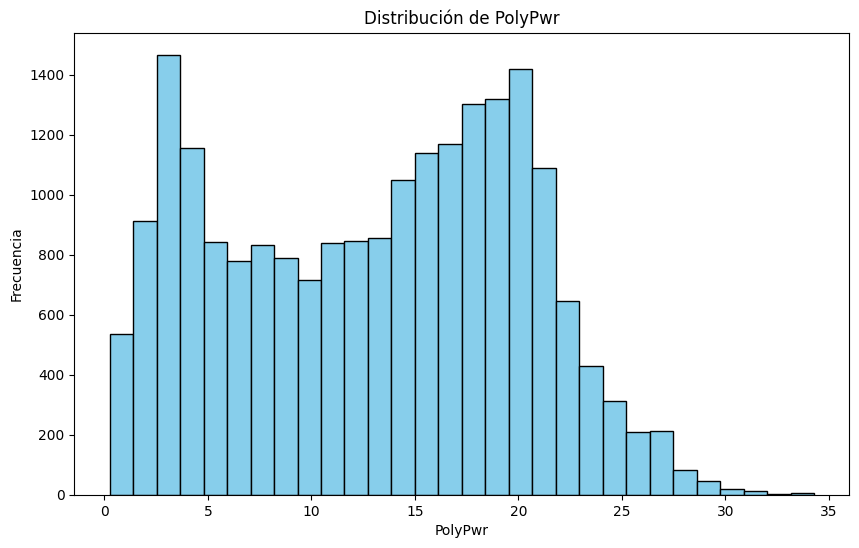

In [ ]:
# crear histograma para la distribucion de 'PolyPwr' (potencia)

plt.figure(figsize=(10,6))
plt.hist(df['PolyPwr'], bins=30, color='skyblue', edgecolor='black')

# etiquetas y titulo
plt.xlabel('PolyPwr') # por identificar la columna pero podria usar potencia o similar
plt.ylabel('Frecuencia')
plt.title('Distribución de PolyPwr')

# mostrar grafico
plt.show()

### Version plotly

Aporta más informacion estas librerias.

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Opción 1: Con graph_objects (más control)
fig = go.Figure(data=[
    go.Histogram(
        x=df['PolyPwr'],
        nbinsx=30,
        marker=dict(
            color='skyblue',
            line=dict(color='black', width=1)
        )
    )
])

fig.update_layout(
    title='Distribución de PolyPwr',
    xaxis_title='PolyPwr',
    yaxis_title='Frecuencia',
    width=1000,
    height=600,
    hovermode='x unified'
)

fig.show()

In [ ]:
# Opción 2: Con express (más compacto)
fig = px.histogram(
    df,
    x='PolyPwr',
    nbins=30,
    title='Distribución de PolyPwr',
    labels={'PolyPwr': 'PolyPwr', 'count': 'Frecuencia'},
    color_discrete_sequence=['skyblue']
)

fig.update_traces(marker_line_color='black', marker_line_width=1)
fig.show()

Este gráfico muestra la distribución de la potencia de salida (PolyPwr) en forma de histograma. El eje horizontal representa los valores de potencia, mientras que el eje vertical muestra la cantidad de apariciones de dichos valores de potencia. El histograma de la distribución de PolyPwr muestra un patrón bimodal, con dos picos principales alrededor de los valores 5 y 20.

Esto indica la existencia de dos grupos principales en los datos, que muy probablemente representan condiciones en las que el panel solar opera a niveles de potencia bajos (por ejemplo, cuando está nublado o durante la noche) y cuando el panel funciona de manera óptima (durante el día con plena radiación solar). Esta distribución no es simétrica y parece estar sesgada hacia la derecha, con algunos valores de potencia bastante altos pero poco frecuentes. Además, la presencia de valores por encima de 30 con una frecuencia muy baja podría tratarse de outliers o datos que necesitan ser investigados más a fondo.

## Gráfico de Violín de la Distribución de PolyPwr vs Variables Meteorológicas

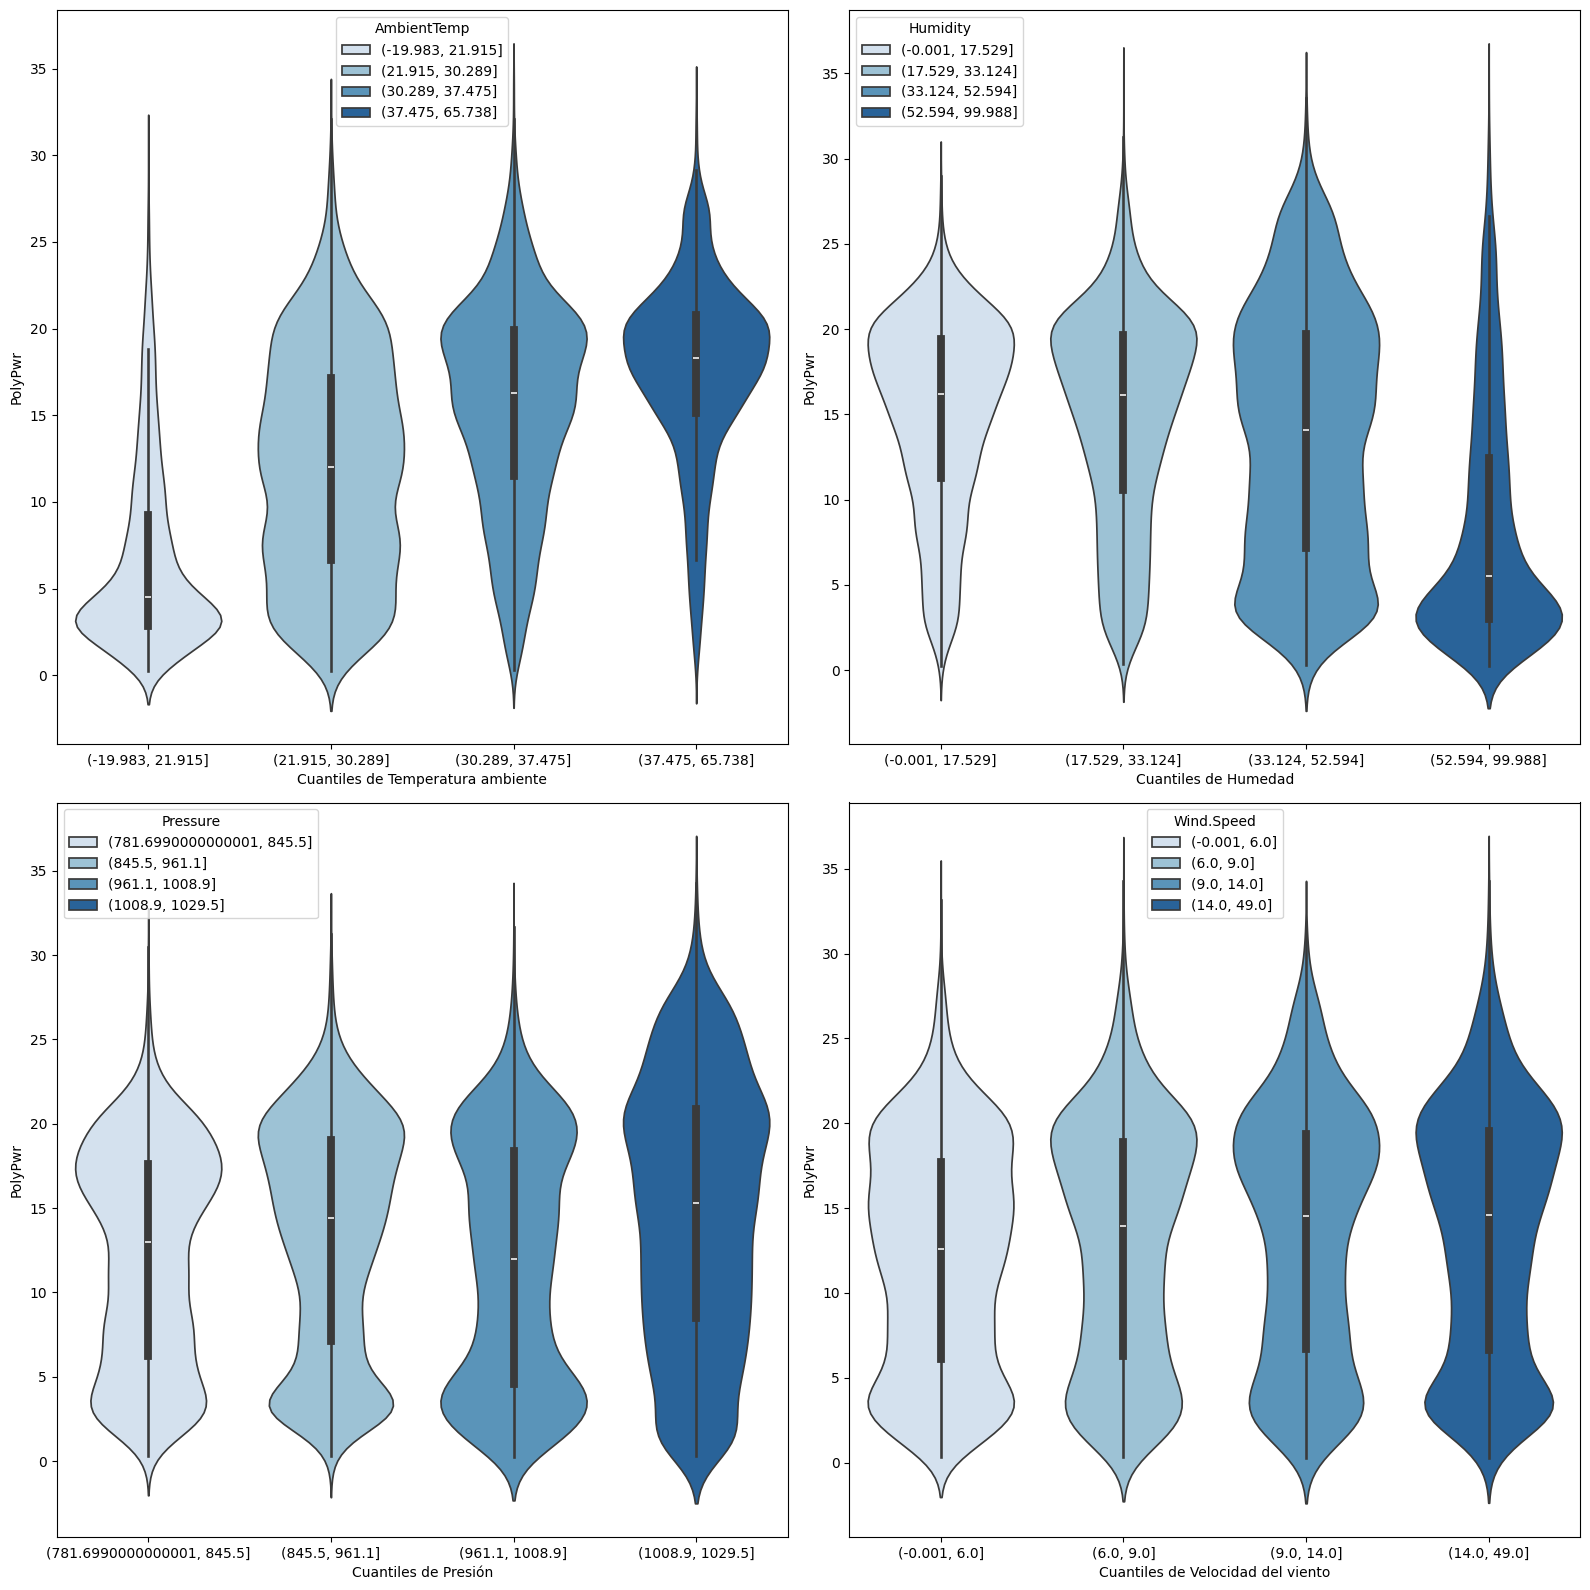

In [ ]:
# crear la figura para los gráficos
plt.figure(figsize=(16,16))

# seleccion de colores desde seaborn
violine_palette = sns.color_palette('Blues', 4)

# lista de variables para el bucle que hace los gráficos
variables = ['AmbientTemp', 'Humidity', 'Pressure', 'Wind.Speed']
titles = [
    'Cuantiles de Temperatura ambiente',
    'Cuantiles de Humedad',
    'Cuantiles de Presión',
    'Cuantiles de Velocidad del viento'
]

# bucle para crear subplots de graficos para esas variables
for i, var in enumerate(variables, 1):
  plt.subplot(2,2,i)
  quantiles = pd.qcut(df[var], q=4)

  sns.violinplot(
      x=quantiles,
      y=df['PolyPwr'],
      hue=quantiles,
      palette=violine_palette,
      legend=True # False para que no salgan las cajitas con la leyenda
  )

  plt.xlabel(titles[i-1])
  plt.ylabel('PolyPwr')

# ajusta y evita la superposicion
plt.tight_layout()

# mostrar la figura
plt.show()



### Version plotly
Aporta más informacion estas librerias.

In [ ]:
from plotly.subplots import make_subplots
# Paleta de colores
colors_palette = ['#08519c', '#3182bd', '#6baed6', '#c6dbef']

variables = ['AmbientTemp', 'Humidity', 'Pressure', 'Wind.Speed']
titles = [
    'Cuantiles de Temperatura ambiente',
    'Cuantiles de Humedad',
    'Cuantiles de Presión',
    'Cuantiles de Velocidad del viento'
]

# Crear subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=titles,
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Llenar subplots
for idx, var in enumerate(variables):
    row = idx // 2 + 1
    col = idx % 2 + 1

    # Crear cuantiles
    quantiles = pd.qcut(df[var], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

    # Añadir violin plot para cada cuantil
    for j, quantile in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
        mask = quantiles == quantile

        fig.add_trace(
            go.Violin(
                x=[quantile] * mask.sum(),
                y=df.loc[mask, 'PolyPwr'],
                name=quantile,
                legendgroup=var,
                line_color=colors_palette[j],
                meanline_visible=True,
                points=False,
                showlegend=(idx == 0)  # Leyenda solo en el primer subplot
            ),
            row=row, col=col
        )

# Actualizar layout
fig.update_yaxes(title_text='PolyPwr', row=1, col=1)
fig.update_yaxes(title_text='PolyPwr', row=1, col=2)
fig.update_yaxes(title_text='PolyPwr', row=2, col=1)
fig.update_yaxes(title_text='PolyPwr', row=2, col=2)

fig.update_layout(
    height=900,
    width=1400,
    showlegend=True,
    hovermode='closest'
)

fig.show()

Este gráfico compara la distribución de la potencia de salida (PolyPwr) en función de diversas variables meteorológicas, como temperatura, humedad, presión del aire y velocidad del viento.

**Interpretación de los componentes del Violin Plot:**

El ancho del violín → Muestra la densidad de los datos. Cuanto más ancho, mayor cantidad de datos tiene ese valor.
La línea central → Al igual que en un boxplot, muestra la mediana y el rango intercuartílico.
La forma del violín simétrica/asimétrica → Indica si la distribución de los datos está sesgada (skewed) hacia una determinada dirección.

**Hallazgos del Violin Plot según las variables meteorológicas:**

**A. Temperatura ambiente vs. PolyPwr**

A temperaturas bajas, la distribución de la potencia tiende a valores pequeños.
A temperaturas medias a altas, la distribución de la potencia es más uniforme y tiende a ser más alta.
Esto indica que los paneles solares funcionan de manera más óptima a temperaturas medias a altas.

**B. Humedad vs. PolyPwr**

A humedades bajas a medias, la distribución de la potencia es bastante amplia y uniforme.
A humedades altas, la distribución de la potencia tiende a ser más baja y más concentrada.
Esto puede deberse al aumento de la cobertura de nubes en condiciones de alta humedad, lo que reduce la radiación solar.

**C. Presión del aire vs. PolyPwr**

La presión del aire baja tiende a estar asociada con una distribución de potencia más amplia, lo que significa mayor variación en la potencia de salida.
A presiones altas, la distribución de la potencia está más enfocada en valores más altos.
La presión alta suele asociarse con clima despejado, lo que puede explicar el aumento de la potencia de salida.

**D. Velocidad del viento vs. PolyPwr**

A velocidades de viento bajas, la potencia de salida es menor y su distribución está más concentrada.
A velocidades de viento medias a altas, la distribución de la potencia es más amplia, pero la potencia de salida tiende a ser mayor.
Las velocidades de viento altas pueden estar relacionadas con condiciones despejadas que incrementan la potencia de salida.

**Conclusión del Violin Plot:**

La temperatura tiene un impacto significativo en la potencia de salida, donde temperaturas medias a altas producen mayor potencia.
La humedad alta tiende a reducir la producción de potencia, probablemente debido al aumento de la cobertura de nubes.
La presión alta se correlaciona con un aumento de la potencia, lo que puede asociarse con clima despejado.
La velocidad del viento media a alta se relaciona con un incremento de la potencia, posiblemente debido a condiciones atmosféricas más despejadas.


> El dataset carece de datos de radiación, valor fundamental que explicaría la correlación entre temperatura y producción, ya que son directamente proporcional.

> Luego se podría calcular la eficiencia real de la instalacion y su relacion con radiación y temperatura, ya que se conoce que a mayor temperatura menor eficiencia, dato interesante para reflejar.

## Box Plot de PolyPwr Basado en la Hora y el Día

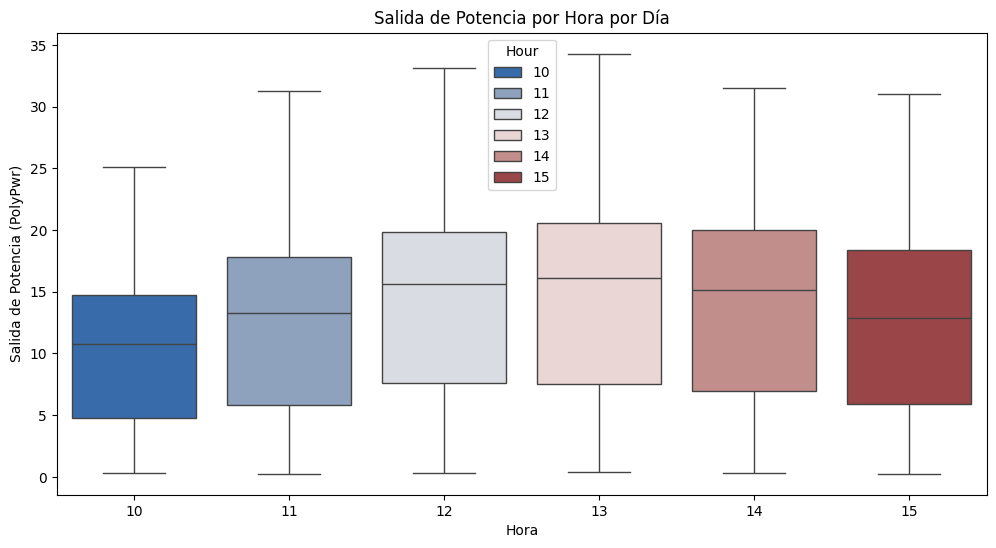

In [ ]:
# Crear una figura con tamaño de 12x6 pulgadas
plt.figure(figsize=(12, 6))

# Crear una paleta de colores usando el esquema 'YlOrBr' con 6 gradaciones de color
boxpwr_palette = sns.color_palette("YlOrBr", n_colors=6)

# Crear un box plot para ver la distribución de la potencia de salida según la hora
sns.boxplot(
    x="Hour",
    y="PolyPwr",
    data=df,
    hue="Hour",
    palette="vlag"
)


# Agregar título y etiquetas de los ejes
plt.title("Salida de Potencia por Hora por Día")
plt.xlabel("Hora")
plt.ylabel("Salida de Potencia (PolyPwr)")

# Mostrar el gráfico
plt.show()


### Version plotly

In [ ]:
fig = px.box(
    df,
    x="Hour",
    y="PolyPwr",
    title="Salida de Potencia por Hora por Día"
)

fig.update_layout(
    xaxis_title="Hora",
    yaxis_title="Salida de Potencia (PolyPwr)"
)

fig.show()

Este gráfico muestra la variación de la potencia de salida (PolyPwr) en varias horas a lo largo de un día utilizando boxplots.

Hallazgos del Boxplot:

* Cada hora en el gráfico tiene una distribución de potencia ligeramente diferente.

* La mediana de la potencia de salida aumenta desde la mañana hasta el mediodía, lo que significa que la potencia generada tiende a ser mayor durante el día.

* La dispersión de los datos es bastante amplia, lo que indica la existencia de una gran variación en la potencia de salida, probablemente causada por factores climáticos como la cobertura de nubes o cambios en la intensidad de la radiación solar.

* Existen algunos outliers, lo que indica que hay ciertos momentos en los que la potencia de salida es mucho más alta o mucho más baja de lo habitual.

Conclusión del Boxplot:

* El boxplot muestra que el patrón de salida de potencia tiende a aumentar hasta alcanzar su punto máximo al mediodía y luego disminuye.

* La variación de la potencia es bastante alta, lo que indica que existen factores externos que influyen en la producción de potencia más allá del tiempo.

## Mapa de Calor de Datos PolyPwr Basado en la Hora y el Mes


**Media (mean)**
La media se obtiene **sumando todos los valores y dividiéndolos entre el total**.
El problema es que **unos pocos valores muy altos o muy bajos** pueden “arrastrar” el resultado y hacer que el promedio **no represente lo que ocurre normalmente**.

Ejemplo simple:
Si casi siempre un panel produce alrededor de 10, pero algunos días muy soleados produce 35, la media sube y puede dar la sensación de que el panel produce más de lo habitual.

---

**Mediana (median)**
La mediana es el **valor que queda justo en el centro** cuando ordenas los datos de menor a mayor.
No le afectan esos valores extremos, por lo que **refleja mejor el comportamiento típico**.

Ejemplo:
Aunque algunos días la producción sea muy alta o muy baja, la mediana sigue mostrando **cuál es el nivel normal de producción**.

---

**Aplicado a este caso (PolyPwr por hora y mes):**

* La **media** puede verse inflada por horas puntuales con sol excepcional o bajada por momentos muy malos.
* La **mediana** muestra mejor **qué producción es la más habitual** en cada hora y mes.

**Conclusión práctica:**
Para entender el comportamiento real y repetible de la producción solar, la **mediana es más fiable** que la media en este dataset.


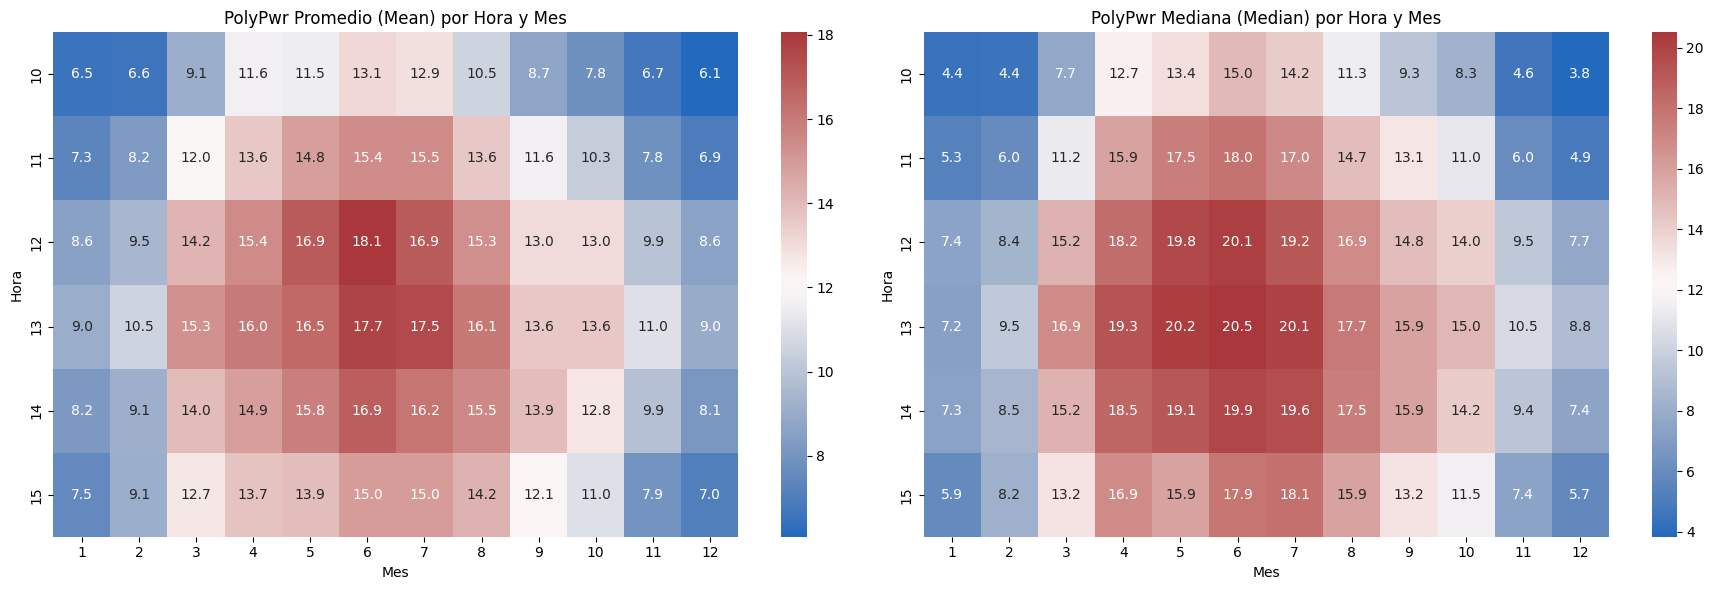

In [ ]:
# version modificada para poder apreciar la diferencia usando media y mediana
# basado en la hora del día (Hour) y el mes (Month)

# Crear una tabla dinámica para calcular el promedio de la potencia de salida (PolyPwr)
# mean (media)
pivot_table_mean = df.pivot_table(
    values= 'PolyPwr',
    index='Hour',
    columns='Month',
    aggfunc='mean'
)

# median (mediana)
pivot_table_median = df.pivot_table(
    values= 'PolyPwr',
    index= 'Hour',
    columns='Month',
    aggfunc='median'
)

# crear figura con dos subplots lado a lado
plt.figure(figsize=(18,6))

# heatmap usando la media (mean)
plt.subplot(1,2,1)
sns.heatmap(
    pivot_table_mean,
    cmap='vlag',
    annot=True,     # Mostrar los valores en cada celda
    fmt='.1f'       # Mostrar números con un decimal
)

plt.title('PolyPwr Promedio (Mean) por Hora y Mes')
plt.xlabel('Mes')
plt.ylabel('Hora')

# heatmap usando la mediana (median)
plt.subplot(1,2,2)
sns.heatmap(
    pivot_table_median,
    cmap='vlag',
    annot=True,
    fmt='.1f'
)

plt.title("PolyPwr Mediana (Median) por Hora y Mes")
plt.xlabel("Mes")
plt.ylabel("Hora")

# ajustar diseño
plt.tight_layout()

# mostrar el gráfico
plt.show()

### Version plotly

In [ ]:
# Crear figura con dos subplots lado a lado
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=[
        "PolyPwr Promedio (Mean) por Hora y Mes",
        "PolyPwr Mediana (Median) por Hora y Mes"
    ]
)

# Heatmap usando la media (mean)
fig.add_trace(
    go.Heatmap(
        z=pivot_table_mean.values,
        x=pivot_table_mean.columns,
        y=pivot_table_mean.index,
        colorscale="RdBu_r",
        # zmid=0,
        text=pivot_table_mean.round(1).values,
        texttemplate="%{text}",
        showscale=True
    ),
    row=1,
    col=1
)

# Heatmap usando la mediana (median)
fig.add_trace(
    go.Heatmap(
        z=pivot_table_median.values,
        x=pivot_table_median.columns,
        y=pivot_table_median.index,
        colorscale="RdBu_r",
        # zmid=0,
        text=pivot_table_median.round(1).values,
        texttemplate="%{text}",
        showscale=True
    ),
    row=1,
    col=2
)

# Etiquetas de ejes
fig.update_xaxes(title_text="Mes", row=1, col=1)
fig.update_xaxes(title_text="Mes", row=1, col=2)
fig.update_yaxes(title_text="Hora", row=1, col=1)
fig.update_yaxes(title_text="Hora", row=1, col=2)

# Ajustes finales
fig.update_layout(
    width=1200,
    height=500
)

fig.show()

Este gráfico es un mapa de calor que muestra el promedio de la potencia de salida (PolyPwr) de los paneles solares según la hora y el mes. El color rojo indica una potencia más alta, mientras que el color azul indica una potencia más baja. A partir de este gráfico, podemos observar que la potencia de salida tiende a ser más alta al mediodía (alrededor de las 12–14) y alcanza su pico entre los meses de mayo y julio. Por el contrario, la potencia es más baja en las horas de la mañana y la tarde, así como en los meses de diciembre y enero, probablemente debido a cambios en la intensidad de la radiación solar a lo largo del año. Esto puede servir como una guía para optimizar el uso de la energía solar de acuerdo con los patrones de producción de potencia generados.

> Se usa la palabra "promedio" como forma simplificada de explicar el gráfico y lo que representa.

## Gráfico de Dispersión de PolyPwr vs Variables Meteorológicas


Este gráfico de dispersión ayuda a comprender si las variables meteorológicas tienen influencia sobre la potencia de salida del panel solar.

* Primer gráfico: Muestra la relación entre la temperatura del aire (AmbientTemp) y PolyPwr (con color azul).
* Segundo gráfico: Muestra la relación entre la humedad (Humidity) y PolyPwr (color verde).
* Tercer gráfico: Muestra la relación entre la presión del aire (Pressure) y PolyPwr (color rojo).
* Cuarto gráfico: Muestra la relación entre la velocidad del viento (Wind Speed) y PolyPwr (color púrpura).


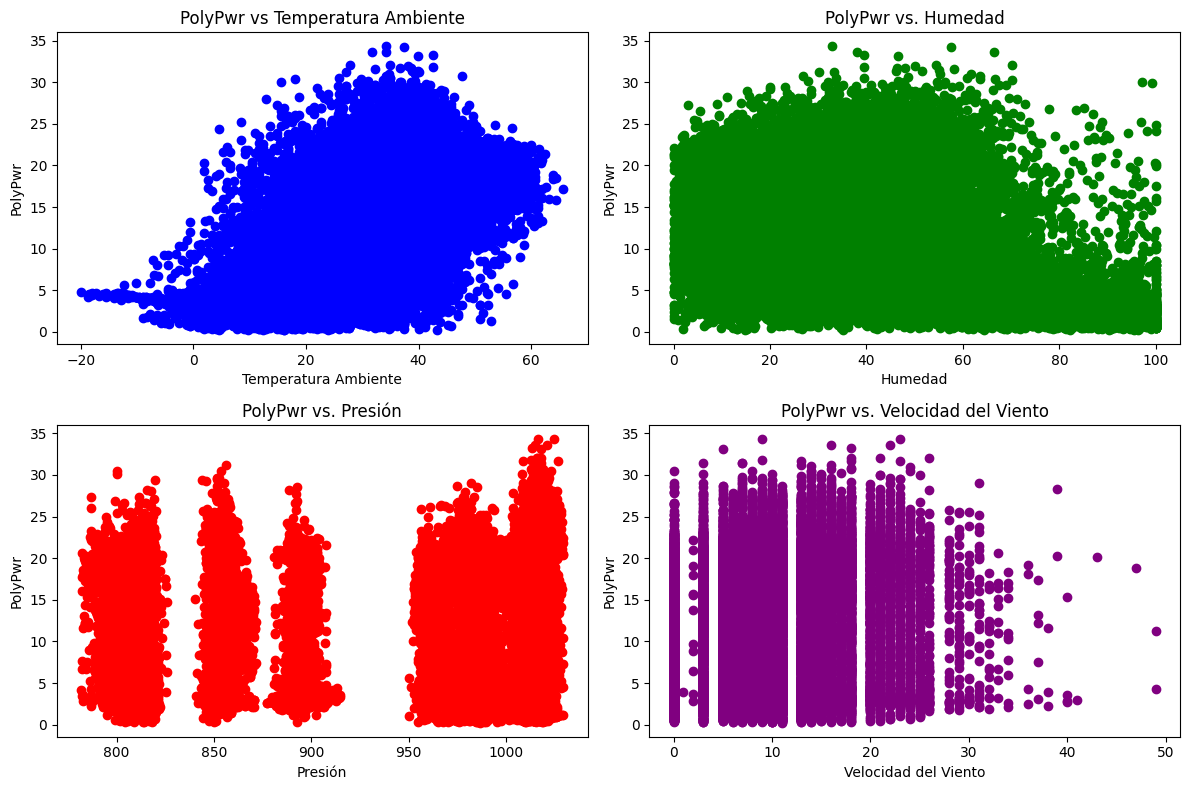

In [ ]:
# Crear una figura y ejes con una cuadrícula 2x2
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# Graficar la relación Temperatura Ambiente vs. PolyPwr
ax[0,0].scatter(df['AmbientTemp'], df['PolyPwr'], color='blue')
ax[0,0].set_xlabel('Temperatura Ambiente')
ax[0,0].set_ylabel('PolyPwr')
ax[0,0].set_title('PolyPwr vs Temperatura Ambiente')

# Graficar la relación Humedad vs. PolyPwr
ax[0, 1].scatter(df["Humidity"], df["PolyPwr"], color="green")
ax[0, 1].set_xlabel("Humedad")
ax[0, 1].set_ylabel("PolyPwr")
ax[0, 1].set_title("PolyPwr vs. Humedad")

# Graficar la relación Presión vs. PolyPwr
ax[1, 0].scatter(df["Pressure"], df["PolyPwr"], color="red")
ax[1, 0].set_xlabel("Presión")
ax[1, 0].set_ylabel("PolyPwr")
ax[1, 0].set_title("PolyPwr vs. Presión")

# Graficar la relación Velocidad del Viento vs. PolyPwr
ax[1, 1].scatter(df["Wind.Speed"], df["PolyPwr"], color="purple")
ax[1, 1].set_xlabel("Velocidad del Viento")
ax[1, 1].set_ylabel("PolyPwr")
ax[1, 1].set_title("PolyPwr vs. Velocidad del Viento")

# Ajustar el diseño para evitar superposición
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### Version plotly

In [ ]:
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=[
        "PolyPwr vs. Temperatura Ambiente",
        "PolyPwr vs. Humedad",
        "PolyPwr vs. Presión",
        "PolyPwr vs. Velocidad del Viento"
    ]
)

fig.add_trace(
    go.Scatter(x=df["AmbientTemp"], y=df["PolyPwr"], mode="markers", marker=dict(color="blue")),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df["Humidity"], y=df["PolyPwr"], mode="markers", marker=dict(color="green")),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=df["Pressure"], y=df["PolyPwr"], mode="markers", marker=dict(color="red")),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df["Wind.Speed"], y=df["PolyPwr"], mode="markers", marker=dict(color="purple")),
    row=2, col=2
)

fig.update_xaxes(title_text="Temperatura Ambiente", row=1, col=1)
fig.update_xaxes(title_text="Humedad", row=1, col=2)
fig.update_xaxes(title_text="Presión", row=2, col=1)
fig.update_xaxes(title_text="Velocidad del Viento", row=2, col=2)

fig.update_yaxes(title_text="PolyPwr", row=1, col=1)
fig.update_yaxes(title_text="PolyPwr", row=1, col=2)
fig.update_yaxes(title_text="PolyPwr", row=2, col=1)
fig.update_yaxes(title_text="PolyPwr", row=2, col=2)

fig.update_layout(
    width=1000,
    height=700,
    showlegend=False
)

fig.show()


La imagen de arriba muestra cuatro gráficos de dispersión que indican la relación entre las variables meteorológicas y la potencia de salida del panel solar (PolyPwr).

**PolyPwr vs. Temperatura Ambiente (Temperatura del Aire – Gráfico Azul)**
La potencia de salida tiende a aumentar a medida que la temperatura sube, pero después de alcanzar cierto punto, la dispersión de los datos se vuelve más aleatoria. Esto indica que la temperatura tiene influencia sobre la potencia de salida, pero no es el único factor.

**PolyPwr vs. Humedad (Humedad – Gráfico Verde)**
La distribución de los datos se dispersa ampliamente sin un patrón claro, lo que indica que la humedad puede no tener una relación fuerte con la potencia de salida del panel solar.

**PolyPwr vs. Presión (Presión del Aire – Gráfico Rojo)**
Los puntos de datos forman grupos según ciertos niveles de presión, que podrían estar relacionados con condiciones meteorológicas. Sin embargo, no se observa un patrón claro de relación entre la presión y la potencia de salida.

**PolyPwr vs. Velocidad del Viento (Velocidad del Viento – Gráfico Púrpura)**
La mayoría de los puntos están distribuidos de manera uniforme, lo que indica que la velocidad del viento puede tener una influencia pequeña o no significativa sobre la potencia de salida del panel solar.

En general, la temperatura parece tener una ligera correlación con la potencia de salida, mientras que las otras variables muestran relaciones más débiles o poco claras.

> Aquí se ratifica que la potencia y temperatura están relacionadas, es conocido que la temperatura al mismo tiempo está relacionada con la radiación. Pero el aumento de tempetura disminuye la potencia final. Por lo tanto, a mayor radiación, mayor temperatura y con este incremento a partir de ciertos valores disminuye la eficiencia por lo que rompe esta relacion lineal entre Producción y radiación.

## Matriz de Correlación de Características Numéricas

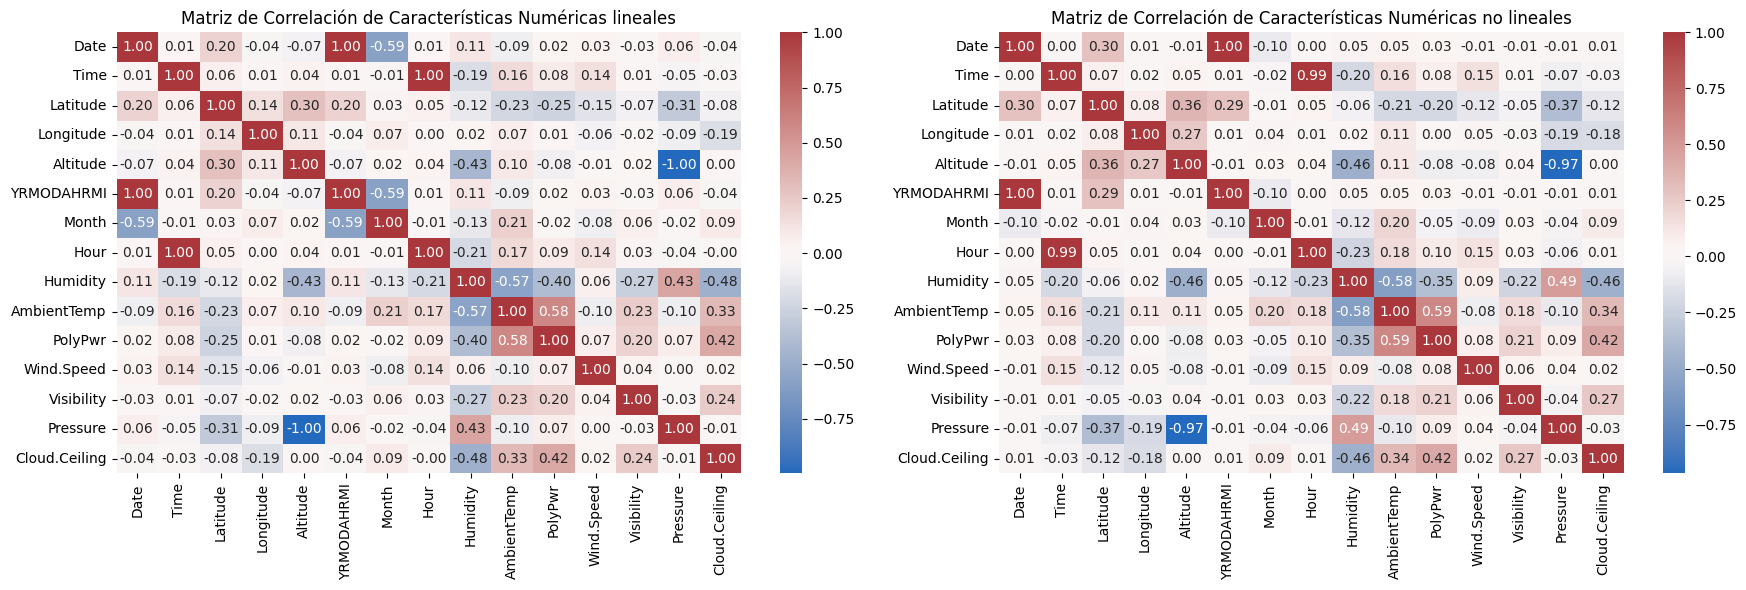

In [ ]:
# En esta version se comparan dos versiones para verificar correlaciones lineales y no lineales
# Seleccionar solo las columnas numéricas para el análisis de correlación
numeric_df = df.select_dtypes(include=('number',))

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Calcular la matriz de correlación no lineales
correlation_matrix_spearman = numeric_df.corr(method="spearman")

# crear figura con dos subplots lado a lado
plt.figure(figsize=(18,6))

# Crear un mapa de calor de correlación
plt.subplot(1,2,1)
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='vlag',
    fmt='.2f'
)

# Agregar título
plt.title("Matriz de Correlación de Características Numéricas lineales")

# Crear un mapa de calor de correlación no lineal
plt.subplot(1,2,2)
sns.heatmap(
    correlation_matrix_spearman,
    annot=True,
    cmap='vlag',
    fmt='.2f'
)

# Agregar título
plt.title("Matriz de Correlación de Características Numéricas no lineales")

# ajustar diseño
plt.tight_layout()

# mostrar el gráfico
plt.show()

Esta imagen muestra la matriz de correlación, que nos ayuda a comprender la relación entre diversas variables numéricas en el dataset. El color rojo indica una correlación positiva fuerte (cercana a +1), lo que significa que si una variable aumenta, la otra también tiende a aumentar. El color azul indica una correlación negativa (cercana a −1), lo que significa que cuando una variable aumenta, la otra tiende a disminuir. Mientras tanto, el color blanco o gris indica una correlación débil o casi inexistente.

A partir de esta matriz, podemos observar que PolyPwr (potencia de salida del panel solar) tiene una correlación bastante alta con la temperatura ambiente (AmbientTemp) y la humedad (Humidity), lo que significa que estos factores pueden influir en la potencia generada. Otras variables, como la presión del aire (Pressure) y la velocidad del viento (Wind Speed), parecen tener una correlación más débil con la potencia de salida. Esta matriz ayuda a seleccionar las características más relevantes para el modelo de predicción de la potencia de salida del panel solar.

> Hay dos gráficos para añadir una capa extra de comparación entre relaciones lineales y no lineales que puedan ser usadas para nuevas interpretaciones.

## Preprocesamiento de Datos

**Traducción literal:**

El preprocesamiento de datos es el proceso de preparación de los datos antes de ser utilizados para el entrenamiento de modelos de machine learning. Este paso es muy importante porque la calidad de los datos influirá en gran medida en los resultados del modelo.

🔢 **Binning**

El binning es una técnica en el procesamiento de datos que se utiliza para dividir los datos numéricos en varios grupos o categorías. El objetivo del binning es facilitar el análisis de datos y reducir la complejidad, especialmente cuando queremos observar patrones en los datos o utilizarlos en modelos de machine learning.


In [ ]:
# Crear bins de PolyPwr usando cuantiles
df["PolyPwr_bins"] = pd.qcut(df["PolyPwr"], q=4, labels=False)

# Posible mejora (breve):
# Conservar etiquetas interpretables:
# labels = ["Muy bajo", "Bajo", "Alto", "Muy alto"]
# df["PolyPwr_bins"] = pd.qcut(df["PolyPwr"], q=4, labels=labels)


Utilizamos la función `pd.qcut()` para dividir los valores de PolyPwr en 4 grupos de cuartiles. Los cuartiles son una forma de dividir los datos en cuatro partes con una cantidad de datos casi igual basándose en su distribución.


## Ingeniería de Características


La *ingeniería de características* es el proceso de transformar datos brutos en características más relevantes e informativas para mejorar el rendimiento de los modelos de machine learning. Su objetivo principal es ayudar al modelo a comprender mejor los patrones en los datos, de modo que aumente la precisión de las predicciones.

La ingeniería de características realizada tiene como objetivo capturar relaciones no lineales e interacciones entre las variables meteorológicas que pueden influir en la potencia de salida del panel solar **(PolyPwr)**.


In [ ]:
# Crear características de interacción
df["Temp_Humidity_Interaction"] = df["AmbientTemp"] * df["Humidity"]
df["Temp_WindSpeed_Interaction"] = df["AmbientTemp"] * df["Wind.Speed"]
df["Humidity_WindSpeed_Interaction"] = df["Humidity"] * df["Wind.Speed"]

# Crear características polinomiales
df["AmbientTemp_squared"] = df["AmbientTemp"] ** 2
df["Humidity_squared"] = df["Humidity"] ** 2
df["WindSpeed_squared"] = df["Wind.Speed"] ** 2

**1. Características de Interacción**

Las interacciones entre las variables meteorológicas pueden reflejar efectos combinados que quizá no sean visibles si solo se utilizan variables individuales.

* **`Temp_Humidity_Interaction`** (Temperatura × Humedad)

  * La temperatura y la humedad suelen interactuar al determinar las condiciones atmosféricas. Una humedad alta puede reducir la eficiencia de enfriamiento de los paneles solares, mientras que una temperatura alta puede aumentar la potencia de salida.

* **`Temp_WindSpeed_Interaction`** (Temperatura × Velocidad del Viento)

  * La velocidad del viento puede ayudar a enfriar los paneles solares, lo que puede mejorar la eficiencia de conversión de energía. Esta interacción captura el efecto combinado entre la temperatura y el viento.

* **`Humidity_WindSpeed_Interaction`** (Humedad × Velocidad del Viento)

  * La combinación de humedad y viento puede influir en el nivel de evaporación y en la presencia de nubes, lo que puede afectar la cantidad de radiación solar que reciben los paneles solares.

**2. Características Polinomiales**

Las características polinomiales ayudan a capturar relaciones no lineales entre las variables meteorológicas y la potencia de salida.

* **`AmbientTemp_squared`** (Temperatura al Cuadrado)

  * La relación entre la temperatura y la potencia de salida no siempre es lineal. Por ejemplo, temperaturas demasiado altas pueden reducir la eficiencia de los paneles solares, por lo que esta característica puede ayudar al modelo a reconocer dicho patrón.

* **`Humidity_squared`** (Humedad al Cuadrado)

  * El efecto de la humedad sobre la potencia de salida puede no ser directo, pero niveles de humedad demasiado altos pueden provocar la formación de nubes y reducir la intensidad de la radiación solar.

* **`WindSpeed_squared`** (Velocidad del Viento al Cuadrado)

  * La velocidad del viento en cierta magnitud puede ser beneficiosa para el enfriamiento de los paneles solares, pero si es demasiado alta, puede causar perturbaciones físicas en los paneles solares o generar efectos de turbulencia que reduzcan la eficiencia.

Al añadir estas características de interacción y polinomiales, se espera que el modelo pueda capturar patrones más complejos y mejorar la precisión de la predicción de la potencia de salida de los paneles solares.


## División de Datos


La *división de datos* es el proceso de separar el dataset en varias partes para entrenar y evaluar modelos de machine learning. Normalmente, los datos se dividen en:

1. **Conjunto de entrenamiento:** Se utiliza para entrenar el modelo.
2. **Conjunto de validación (opcional):** Se utiliza para ajustar los parámetros del modelo y evitar el sobreajuste.
3. **Conjunto de prueba:** Se utiliza para medir el rendimiento final del modelo con datos que nunca han sido vistos.

En primer lugar, se eliminan las características que no están directamente relacionadas con el clima — como la ubicación, el tiempo y la información geográfica — para centrarse únicamente en las características meteorológicas. El objetivo que se desea predecir es la potencia de salida del panel solar (`PolyPwr`).


Para que la división de datos sea equilibrada según los valores de potencia, los datos se dividen utilizando el método de estratificación basado en los cuartiles de los valores de `PolyPwr`, lo que significa que los datos se agrupan en 4 niveles (desde el más bajo hasta el más alto). A continuación, el 70 % de los datos se utiliza para entrenar el modelo, y el 30 % restante se divide nuevamente en dos partes del mismo tamaño para fines de validación y prueba (15 % del total de los datos cada uno). La validación se utiliza para evaluar el rendimiento del modelo durante el entrenamiento, mientras que la prueba se utiliza para evaluar qué tan bien funciona el modelo con datos nuevos que nunca han sido vistos anteriormente. Esta división es importante para que el modelo no solo funcione bien con los datos de entrenamiento, sino que también pueda desempeñarse bien en el mundo real.


In [ ]:
# Definir las características (X) y el objetivo (y)
X = df.drop(columns=[
    "PolyPwr", "Location", "Date", "Time", "Latitude", "Longitude", "Altitude",
    "YRMODAHRMI", "Month", "Hour", "Season", "Datetime"
])

y = df["PolyPwr"]

# Convertir 'Datetime' a timestamp Unix
# X['Datetime'] = X['Datetime'].astype('int64')

# Estratificación basada en los cuartiles de 'PolyPwr'
y_quantiles = pd.qcut(y, q=4, labels=False)


# Dividir los datos en entrenamiento (70%) y temporal (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.7, random_state=42, stratify=y_quantiles
)

# Dividir los datos temporales en validación (15%) y prueba (15%)
y_temp_quantiles = pd.qcut(y_temp, q=4, labels=False)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp_quantiles
)

# Mostrar el tamaño de los resultados de la división
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (14731, 13), y_train shape: (14731,)
X_val shape: (3157, 13), y_val shape: (3157,)
X_test shape: (3157, 13), y_test shape: (3157,)



Ese resultado muestra el resultado del proceso de *data splitting* o división de datos en tres partes principales: datos de entrenamiento (*training*), datos de validación (*validation*) y datos de prueba (*test*).

En este caso, hay 14.731 datos que se utilizan para entrenar el modelo (X_train y y_train), donde cada dato tiene 13 características o variables de entrada que se usan para predecir el objetivo. Luego, hay 3.157 datos para la validación del modelo (X_val y y_val), que se utilizan para evaluar el rendimiento del modelo durante el entrenamiento y ayudar en el proceso de ajuste (*tuning*) de los parámetros del modelo. Por último, existen otros 3.157 datos que se utilizan para medir la precisión del modelo con datos completamente nuevos (X_test y y_test), es decir, datos que el modelo nunca ha visto antes durante el entrenamiento.

Con esta división, podemos asegurarnos de que el modelo creado no solo funcione bien con los datos de entrenamiento, sino que también sea capaz de trabajar correctamente con datos nuevos que no conocía previamente.


## Construcción del Modelo


 **Entrenamiento del Modelo**

El entrenamiento del modelo es el proceso de entrenar un modelo de machine learning con datos para que pueda aprender patrones y relaciones entre las características (X) y el objetivo (y).





**1. Regresión Lineal**

La regresión lineal es un modelo que intenta trazar la línea recta que mejor se ajusta a los datos que tenemos. En el caso de estudio de predicción de la potencia de paneles solares, este modelo intentará encontrar relaciones lineales entre factores como la temperatura, la humedad y la velocidad del viento con la potencia de salida del panel solar. Por ejemplo, a mayor temperatura, la potencia generada podría ser menor. La regresión lineal es un modelo sencillo y fácil de entender, pero en ocasiones no es suficiente para manejar relaciones más complejas.

In [ ]:
# Modelo de Regresión Lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_val_lr = lr_model.predict(X_val)
y_pred_test_lr = lr_model.predict(X_test)


**2. Regresión por Vectores de Soporte (SVR)**

SVR es un modelo más avanzado que la regresión lineal. En lugar de trazar una línea recta, SVR intenta encontrar la “línea” o “curva” óptima que pueda predecir la potencia del panel solar con mayor precisión, especialmente cuando los datos presentan patrones no lineales. SVR funciona buscando los puntos que están más cerca de los datos, con una pequeña tolerancia al error.

In [ ]:
# Modelo de Regresión por Vectores de Soporte (SVR)
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train, y_train)

y_pred_val_svr = svr_model.predict(X_val)
y_pred_test_svr = svr_model.predict(X_test)

**3. Regresión con Árbol de Decisión**

El *árbol de decisión* es un modelo que toma decisiones dividiendo los datos en varias partes, como las ramas de un árbol. En el caso de los paneles solares, este modelo dividirá los datos según distintas condiciones (por ejemplo, temperatura o humedad) para predecir la potencia de salida. Si la temperatura es alta, la primera rama podría indicar una disminución de la potencia. Este modelo es fácil de entender y puede manejar datos complejos, pero puede ser muy sensible a datos inconsistentes (overfitting).

In [ ]:
# Modelo de Regresión con Árbol de Decisión
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_val_dt = dt_model.predict(X_val)
y_pred_test_dt = dt_model.predict(X_test)

**4. Regresión con Random Forest**

*Random Forest* es un conjunto de muchos árboles de decisión. Cada árbol realiza una predicción y el resultado final es el promedio de todos los árboles. Esto ayuda a reducir el problema de overfitting que puede ocurrir en un árbol de decisión individual. En la predicción de la potencia de paneles solares, Random Forest puede ser más estable y preciso porque utiliza múltiples modelos para generar la predicción, lo que lo hace más confiable cuando las condiciones meteorológicas son variables.

In [ ]:
# Modelo de Regresión con Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_val_rf = rf_model.predict(X_val)
y_pred_test_rf = rf_model.predict(X_test)

**5. XGBoost**

*XGBoost* es un modelo muy potente y eficiente para problemas de predicción. Es una técnica de boosting, lo que significa que este modelo construye varios árboles de decisión de forma gradual, donde cada árbol intenta corregir los errores cometidos por el árbol anterior. En el proyecto de predicción de la potencia de paneles solares, XGBoost modelará relaciones muy complejas entre variables como la temperatura, el viento y la humedad para ofrecer resultados más precisos que otros modelos, especialmente en datos grandes y complejos.

In [ ]:
# Modelo de Regresión XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_val_xgb = xgb_model.predict(X_val)
y_pred_test_xgb = xgb_model.predict(X_test)

## Evaluación del Modelo

En este proyecto se utilizan cinco métricas de evaluación para medir el rendimiento de los modelos de regresión:

1. **Error Cuadrático Medio (MSE):** Mide el promedio del cuadrado de la diferencia entre los valores predichos y los valores reales.
2. **Raíz del Error Cuadrático Medio (RMSE):** Es la raíz cuadrada del MSE y proporciona una interpretación en la misma escala que la variable objetivo.
3. **Error Absoluto Medio (MAE):** Mide el promedio del valor absoluto de la diferencia entre los valores predichos y los valores reales.
4. **Error Porcentual Absoluto Medio (MAPE):** Mide el porcentaje promedio del error absoluto y proporciona una interpretación en forma de porcentaje.
5. **Coeficiente de Determinación (R²):** Mide la proporción de la variación en la variable objetivo que es explicada por el modelo.

In [ ]:
# Función de evaluación del modelo con MAPE adicional y salida en forma de tabla
def evaluate_model(y_true, y_pred, model_name, results_df, add_separator=False):
  """
    Calcula métricas de evaluación incluyendo MAPE y las guarda en un DataFrame.

    Parámetros:
    - y_true: array, valores reales del objetivo
    - y_pred: array, valores predichos por el modelo
    - model_name: str, nombre del modelo evaluado
    - results_df: DataFrame, contenedor de los resultados de evaluación
    - add_separator: bool, si es True agrega una fila vacía previa para separar modelos distintos

    Retorna:
    - DataFrame con los resultados de evaluación actualizados
  """

  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  # Calcular Mean Absolute Percentage Error (MAPE)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

  new_row = pd.DataFrame({
      'Modelo': [model_name],
      'MSE': [mse],
      'RMSE': [rmse],
      'MAE': [mae],
      'MAPE (%)': [mape],
      'R² Score': [r2]
  })

  # Si se necesita un separador entre modelos distintos, agregar una fila vacía
  if add_separator:
    separator = pd.DataFrame({
        'Modelo': [''],
        'MSE': [''],
        'RMSE': [''],
        'MAE': [''],
        'MAPE (%)': [''],
        'R² Score': ['']
    })


    results_df = pd.concat([results_df, separator], ignore_index=True)

  return pd.concat([results_df, new_row], ignore_index=True)


# DataFrame vacío para almacenar los resultados de evaluación
results = pd.DataFrame(columns=["Modelo", "MSE", "RMSE", "MAE", "MAPE (%)", "R² Score"])

# Regresión Lineal (Validación y Test)
results = evaluate_model(y_val, y_pred_val_lr, "Regresión Lineal (Validación)", results)
results = evaluate_model(y_test, y_pred_test_lr, "Regresión Lineal (Test)", results)

# Support Vector Regression (Validación y Test)
results = evaluate_model(y_val, y_pred_val_svr, "Support Vector Regression (Validación)", results, add_separator=True)
results = evaluate_model(y_test, y_pred_test_svr, "Support Vector Regression (Test)", results)

# Árbol de Decisión (Validación y Test)
results = evaluate_model(y_val, y_pred_val_dt, "Regresión Árbol de Decisión (Validación)", results, add_separator=True)
results = evaluate_model(y_test, y_pred_test_dt, "Regresión Árbol de Decisión (Test)", results)

# Random Forest (Validación y Test)
results = evaluate_model(y_val, y_pred_val_rf, "Random Forest Regression (Validación)", results, add_separator=True)
results = evaluate_model(y_test, y_pred_test_rf, "Random Forest Regression (Test)", results)

# XGBoost (Validación y Test)
results = evaluate_model(y_val, y_pred_val_xgb, "XGBoost Regression (Validación)", results, add_separator=True)
results = evaluate_model(y_test, y_pred_test_xgb, "XGBoost Regression (Test)", results)

# Mostrar resultados de evaluación con separación visual entre modelos
display(results.style.set_properties(**{"text-align": "left"}))



/tmp/ipython-input-3117277254.py:48: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Los resultados de la evaluación anterior muestran el rendimiento de cinco modelos de regresión en la predicción de la potencia de salida de los paneles solares (`PolyPwr`) basándose en los datos de validación y de prueba. La evaluación se realizó utilizando varias métricas: **MSE (Error Cuadrático Medio)**, **RMSE (Raíz del Error Cuadrático Medio)**, **MAE (Error Absoluto Medio)**, **MAPE (%)** (porcentaje medio del error absoluto) y **R² Score** (qué tan bien el modelo explica la variación de los datos).

* El modelo de *Regresión Lineal* también muestra un buen rendimiento, con valores de error relativamente bajos y un R² por encima de 0.92, lo que significa que el modelo es bastante bueno, aunque no tan preciso como *Random Forest*.

* Por el contrario, la *Regresión por Vectores de Soporte (SVR)* muestra un rendimiento muy pobre. Sus valores de error son muy altos y su R² es cercano a cero, lo que significa que el modelo casi no logra capturar correctamente los patrones de los datos.

* La *Regresión con Árbol de Decisión* tiene un desempeño bastante bueno, aunque aún por debajo de *Random Forest* y *Regresión Lineal*, con valores de error ligeramente más altos y un R² alrededor de 0.89.

* La *Regresión XGBoost* también presenta un rendimiento sólido, casi comparable al de *Random Forest*, con un R² cercano a 0.94 en validación y 0.93 en test. Esto indica que *XGBoost* también es capaz de proporcionar predicciones precisas.

* El modelo *Random Forest* muestra un rendimiento muy bueno en la predicción de la potencia de salida de los paneles solares. Esto puede observarse a partir de los siguientes valores de las métricas de evaluación:

  * El valor de MSE en los datos de validación es 2.99 y el RMSE es 1.73. En los datos de prueba, el MSE aumenta ligeramente a 3.10 y el RMSE a 1.76. Esto indica que el error promedio de predicción del modelo se sitúa alrededor de 1.7 unidades de potencia (vatios). La pequeña diferencia entre validación y test indica que el modelo es estable y no presenta sobreajuste.

  * El MAE en validación es 1.36, mientras que en test es 1.38. Esto significa que, en promedio, las predicciones del modelo se desvían alrededor de 1.3–1.4 unidades respecto al valor real, lo cual representa un nivel de error bajo.

  * El MAPE muestra que las predicciones del modelo se desvían alrededor de un 19 % en los datos de validación y un 21 % en los datos de test con respecto al valor real de forma relativa. Esto es bastante bueno para datos del mundo real, especialmente para predicciones basadas en factores meteorológicos que pueden ser muy dinámicos.

  * El valor de R² en los datos de validación es 0.941 y en los datos de test es 0.940. Este valor es muy alto (cercano a 1), lo que significa que el modelo es capaz de explicar más del 94 % de la variación de la variable objetivo (`PolyPwr`) a partir de las variables meteorológicas utilizadas.


## Selección de Características

La selección de características es el proceso de elegir las características (columnas de datos) que tienen mayor influencia en los resultados de la predicción, de modo que el modelo construido sea más simple, más rápido y siga siendo preciso.

En este proceso, la selección de características se realiza utilizando el modelo *Random Forest*. Primero, se entrena un modelo *Random Forest Regressor* utilizando todas las características disponibles. Después, se utiliza `SelectFromModel`, una herramienta de scikit-learn que selecciona automáticamente las características que tienen mayor influencia en la predicción, basándose en los valores de “importance” del *Random Forest*.

Las características cuyo valor de importancia está por encima del valor mediano serán seleccionadas, mientras que el resto será ignorado. Una vez seleccionadas las características importantes, los datos de entrenamiento, validación y prueba se transforman para que solo contengan dichas características seleccionadas. Posteriormente, se entrena nuevamente un nuevo modelo *Random Forest* utilizando únicamente estas características. El objetivo es comprobar si el modelo aún puede funcionar correctamente a pesar de utilizar menos características. Por último, el modelo se evalúa y los resultados de la evaluación se agregan a la tabla de resultados (`results`) para compararlos con los modelos anteriores.

In [ ]:
# Modelo de Regresión con Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Selección de características usando SelectFromModel
# Eliminar características con importance por debajo del valor mediano
selector = SelectFromModel(estimator=rf_model, threshold='median')
selector.fit(X_train, y_train)

# Aplicar la selección de características a los datos de entrenamiento, validación y prueba
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Obtener los nombres de las características seleccionadas
selected_feature_indices = selector.get_support(indices=True)
selected_features = list(X_train.columns[selected_feature_indices])
print("Características seleccionadas:", selected_features)

# Volver a entrenar el modelo Random Forest con las características seleccionadas
rf_selected_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selected_model.fit(X_train_selected, y_train)

# Evaluar el modelo con las características seleccionadas
y_pred_val_rf_selected = rf_selected_model.predict(X_val_selected)
y_pred_test_rf_selected = rf_selected_model.predict(X_test_selected)

# Añadir los resultados de la evaluación al DataFrame
results = evaluate_model(
    y_val,
    y_pred_val_rf_selected,
    "Random Forest (Características Seleccionadas) - Validación",
    results,
    add_separator=True
)

results = evaluate_model(
    y_test,
    y_pred_test_rf_selected,
    "Random Forest (Características Seleccionadas) - Test",
    results
)

display(results.style.set_properties(**{"text-align": "left"}))

Características seleccionadas: ['AmbientTemp', 'Pressure', 'PolyPwr_bins', 'Temp_Humidity_Interaction', 'Temp_WindSpeed_Interaction', 'Humidity_WindSpeed_Interaction', 'AmbientTemp_squared']


Los resultados de la evaluación del modelo *Random Forest* antes y después de realizar la selección de características muestran que el rendimiento del modelo sigue siendo muy bueno, a pesar de que el número de características se ha reducido. En el modelo sin selección de características, *Random Forest* produjo un valor de MSE de 2.99 en los datos de validación y de 3.09 en los datos de prueba (test), así como un valor de R² de 0.94 en ambos conjuntos de datos. Esto significa que el modelo es capaz de explicar aproximadamente el 94 % de la variación de la potencia de salida del panel solar, lo cual es un resultado muy preciso.


Después de realizar la selección de características, el modelo solo utiliza algunas características consideradas más importantes, a saber: `AmbientTemp`, `Pressure`, `PolyPwr_bins`, `Temp_Humidity_Interaction`, `Temp_WindSpeed_Interaction`, `Humidity_WindSpeed_Interaction` y `AmbientTemp_squared`. A pesar de usar menos características, los resultados de la evaluación siguen siendo muy buenos. El MSE solo aumenta ligeramente a 3.06 (validación) y 3.24 (test), y el valor de R² sigue siendo alto, es decir, 0.939 y 0.937 respectivamente.


En otras palabras, utilizar características seleccionadas permite que el modelo continúe proporcionando predicciones precisas al mismo tiempo que reduce la complejidad. Esto demuestra que no todas las características son necesarias para producir un buen modelo, y que es posible mantener una alta precisión utilizando únicamente las características que son realmente relevantes.

In [ ]:
# Guardar el modelo Random Forest
filename = ruta + "rf_model.pkl"
pickle.dump(rf_model, open(filename, "wb"))
print(f"Modelo guardado en {filename}")

Modelo guardado en /content/drive/MyDrive/kaggle/Forecasting fotovoltaico/rf_model.pkl


## Inferencia


El proceso de inferencia en machine learning es la etapa en la que un modelo ya entrenado se utiliza para realizar predicciones sobre datos nuevos que nunca ha visto antes. En el contexto de la regresión, el modelo recibe un conjunto de características como entrada y produce un valor de predicción como salida. Primero, los datos de prueba se proporcionan al modelo, que luego realiza cálculos basados en los parámetros que ha aprendido durante el entrenamiento. El modelo utiliza reglas o patrones que ha aprendido a partir de los datos de entrenamiento para estimar el resultado más probable. Después de que se generan las predicciones, estos resultados pueden compararse con los valores reales para evaluar el rendimiento del modelo. En muchos casos, los resultados de la inferencia se visualizan mediante gráficos o métricas de evaluación como MSE, RMSE o R² para comprender qué tan bien funciona el modelo en condiciones del mundo real.

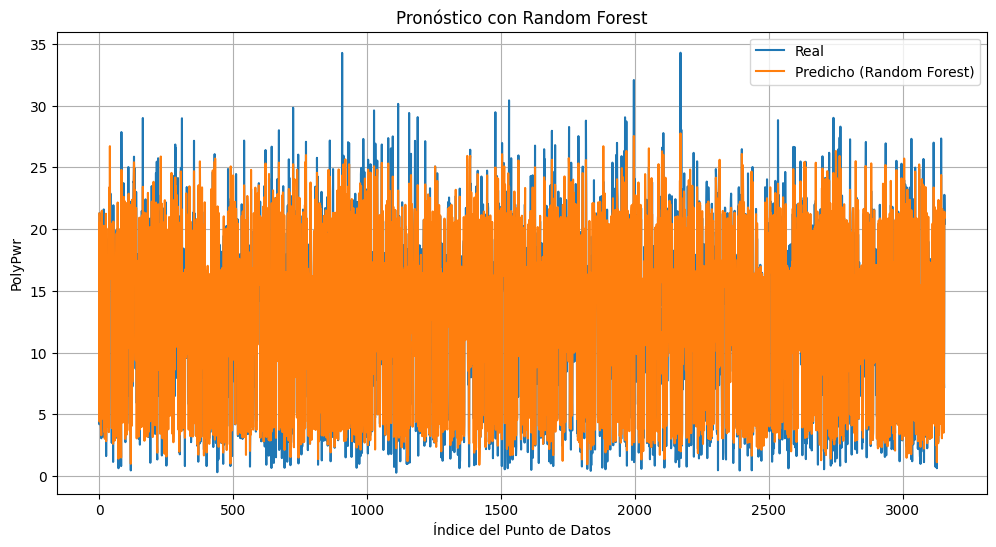

In [ ]:
# Realizar predicciones usando el modelo Random Forest
y_pred_rf = rf_model.predict(X_test)

# Crear un gráfico de los resultados de la predicción
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Real")
plt.plot(y_pred_rf, label="Predicho (Random Forest)")

# Agregar etiquetas y título
plt.xlabel("Índice del Punto de Datos")
plt.ylabel("PolyPwr")
plt.title("Pronóstico con Random Forest")

# Mostrar leyenda y cuadrícula
plt.legend()
plt.grid(True)
plt.show()


El gráfico de arriba muestra los resultados de la predicción de la potencia de los paneles solares (`PolyPwr`) utilizando el modelo *Random Forest*, comparados con los valores reales.

* La línea azul representa los datos reales (*Real*) medidos directamente del sistema.
* La línea naranja representa los resultados de la predicción del modelo (*Predicho*) basados en los patrones de los datos anteriores.

A partir de este gráfico, se observa que las predicciones del modelo siguen bastante bien el patrón de los datos reales, aunque existen algunas pequeñas desviaciones. Algunos puntos de predicción pueden no coincidir siempre exactamente con los datos originales, pero el patrón general sigue siendo similar.

**Análisis General:**

* El modelo es capaz de capturar las tendencias principales de los datos.
* Sin embargo, debido a que los datos son bastante fluctuantes y presentan mucha variación, el modelo en ocasiones comete errores de predicción.
* Si existen muchas diferencias entre la línea azul y la naranja, podría ser necesario mejorar el modelo, por ejemplo, ajustando los parámetros o probando otros algoritmos.

En general, este modelo ya es bastante bueno para predecir la potencia de los paneles solares, pero aún puede mejorarse para obtener resultados más precisos.


## Inferencia en Tiempo Real

A continuación se presenta la predicción de la potencia de salida de los paneles solares en tiempo real utilizando datos meteorológicos obtenidos de *OpenWeatherMap*. El usuario solo necesita introducir el nombre de la ciudad y, a continuación, el programa obtendrá los datos de temperatura, humedad y velocidad del viento de dicha ciudad. Después, los datos meteorológicos obtenidos se procesan para convertirse en características que sean compatibles con el modelo *Random Forest* previamente entrenado. Este modelo utiliza posteriormente esos datos para predecir la cantidad de potencia eléctrica en vatios (**W**) generada por los paneles solares bajo las condiciones meteorológicas actuales. El resultado de la predicción se muestra en pantalla, de modo que el usuario puede ver directamente la estimación de la potencia de salida del panel solar en función de las condiciones meteorológicas más recientes.

In [ ]:
# Cargar el modelo Random Forest previamente entrenado
pickle_file = ruta + "rf_model.pkl"
with open(pickle_file, 'rb') as f:
  rf_model = pickle.load(f)

# Clave API de OpenWeatherMap
API_KEY = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

def get_weather_data(api_key, city_name):
  """
    Obtener datos meteorológicos desde OpenWeatherMap según el nombre de la ciudad.

    Parámetros:
    - api_key (str): Clave API de OpenWeatherMap.
    - city_name (str): Nombre de la ciudad de la cual se desean obtener los datos.

    Retorna:
    - temperature (float): Temperatura en grados Celsius.
    - humidity (float): Humedad en porcentaje.
    - wind_speed (float): Velocidad del viento en metros por segundo.
  """

  base_url = 'http://api.openweathermap.org/data/2.5/weather?'
  complete_url = f'{base_url}appid={api_key}&q={city_name}&units=metric'

  response = requests.get(complete_url)
  data = response.json()

  if data['cod'] != '404':
    temperature = data['main']['temp']
    humidity = data['main']['humidity']
    wind_speed = data['wind']['speed']
    return temperature, humidity, wind_speed

  print(f"Ciudad no encontrada: {city_name}")
  return None, None, None



def inference(rf_model, temperature, humidity, wind_speed):
  """
    Realizar la predicción de la potencia de salida del panel solar
    basándose en temperatura, humedad y velocidad del viento.

    Parámetros:
    - rf_model: Modelo Random Forest entrenado.
    - temperature (float): Temperatura en grados Celsius.
    - humidity (float): Humedad en porcentaje.
    - wind_speed (float): Velocidad del viento en metros por segundo.

    Retorna:
    - prediction (float): Predicción de la potencia de salida del panel solar en kW.
  """

  # Obtener el tiempo actual en formato timestamp (milisegundos)
  current_time = int(datetime.now().timestamp() * 1000)

  # Obtener los nombres de las características usadas en el entrenamiento
  feature_names = rf_model.feature_names_in_

  # Crear un diccionario con todas las características inicializadas en 0
  input_data_dict = {feature: 0 for feature in feature_names}

  # Actualizar el diccionario con los datos meteorológicos disponibles
  input_data_dict.update({
        'AmbientTemp': temperature,
        'Humidity': humidity,
        'Wind.Speed': wind_speed,
        'Temp_Humidity_Interaction': temperature * humidity,
        'Temp_WindSpeed_Interaction': temperature * wind_speed,
        'Humidity_WindSpeed_Interaction': humidity * wind_speed,
        'AmbientTemp_squared': temperature ** 2,
        'Humidity_squared': humidity ** 2,
        'WindSpeed_squared': wind_speed ** 2
    })

  # Crear un DataFrame a partir del diccionario
  input_data = pd.DataFrame([input_data_dict])

  # Realizar la predicción con el modelo
  prediction = rf_model.predict(input_data)

  return prediction[0]



if __name__ == "__main__":
    city_name = input("Introduzca el nombre de la ciudad: ")
    temperature, humidity, wind_speed = get_weather_data(API_KEY, city_name)

    if temperature is not None and humidity is not None and wind_speed is not None:
        print(f"\nDatos Meteorológicos de {city_name}:")
        print(f"- Temperatura: {temperature}°C")
        print(f"- Humedad: {humidity}%")
        print(f"- Velocidad del viento: {wind_speed} m/s")

        # Realizar la predicción de la potencia de salida del panel solar
        predicted_power = inference(rf_model, temperature, humidity, wind_speed)
        print(f"\nPredicción de la Potencia de Salida del Panel Solar: {predicted_power:.2f} W")
    else:
        print("Error al obtener los datos meteorológicos.")

Introduzca el nombre de la ciudad: Pekanbaru

Datos Meteorológicos de Pekanbaru:
- Temperatura: 25.18°C
- Humedad: 94%
- Velocidad del viento: 0 m/s

Predicción de la Potencia de Salida del Panel Solar: 3.77 W


La ciudad de ejemplo es `Pekanbaru`